# Studying the relationships among food insecurity, covid transmission, and demographics in Chicago zip codes

In [21]:
# Dependencies
import requests
import pandas as pd
from census import Census
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import warnings
warnings.filterwarnings("ignore")


In [22]:
# read in csv file of Chicago zip codes
# Obtained from: https://www.zillow.com/browse/homes/il/cook-county/
zip_df = pd.read_csv("ChicagoZips.csv", encoding="utf-8")

In [23]:
# Read in Grocery store information.
# Information obtained from: https://data.cityofchicago.org/Health-Human-Services/Grocery-Store-Status/3e26-zek2/data
store_df=pd.read_csv("Grocery_Store_Status_UseMe.csv" , encoding="utf-8")
store_df[["Zipcode","Zipcode_long"]]=store_df.Zip_long.str.split("-",expand=True)

store_df["Zipcode"]=store_df["Zipcode"].astype("int64")
store_df=store_df[store_df["New status"]=="OPEN"]


In [24]:
#Calculating the total number of stores within each zip code and only retaining one column with that information
store_count_df=store_df.groupby("Zipcode").count()
store_count_df=store_count_df[["Address"]]
store_count_df= store_count_df.rename(columns = {"Address": "Store Count"})

In [25]:
# Read in covid 19 information. 
# Obtained from: https://data.cityofchicago.org/widgets/yhhz-zm2v?mobile_redirect=true
covid_df = pd.read_csv("COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code.csv", encoding="utf-8")
covid_df= covid_df.rename(columns = {"ZIP Code": "Zipcode"})
covid_df = covid_df[(covid_df["Zipcode"].str.contains("Unknown"))==False]

covid_df["Zipcode"]=covid_df["Zipcode"].astype("int64")
covid_df=covid_df.dropna(how="any")

In [26]:
# Covid data are presented by day from March 2020 to August 5, 2023 for Chicagoland zipcodes. We are taking the total number of reported cases, tests administered, and deaths for each zip code and converting to percents.
# Because we are taking the cumulative total, people can get tested more than once or have covid more than once, so those percentages can (and do) exceed 100%. Death rates cannot and do not. 
cases=covid_df.groupby(["Zipcode"])["Cases - Cumulative"].max()
tests=covid_df.groupby(["Zipcode"])["Tests - Cumulative"].max()
deaths=covid_df.groupby(["Zipcode"])["Deaths - Cumulative"].max()

covid_comps=pd.DataFrame({"Total Covid Cases": cases,
                          "Total Covid Tests": tests,
                          "Total Covid Deaths": deaths
})
covid_comps.head()

,Total Covid Cases,Total Covid Tests,Total Covid Deaths
Zipcode,,,
60601,5599.0,104433,15
60602,489.0,12516,3
60603,437.0,12056,0
60604,477.0,15782,0
60605,7628.0,138839,15


In [27]:
# Import U.S. Census API Key. This cell is from the census_data lesson that was done in class.
from config import api_key

# Create an instance of the Census library
c = Census(
    api_key,
    year = 2020
)


In [28]:
# Pulling census data from API. This cell was adapted from the census_data lesson that was done in class.  
census_data = c.acs5.get(
    (
        "NAME",
        "B19013_001E",
        "B01003_001E",
        "B01002_001E",
        "B19301_001E",
        "B17001_002E",
        "B15003_002E",
        "B15003_017E",
        "B15003_018E", 
        "B15003_022E", 
        "B23025_004E",
        "B23025_005E"


    ),
    {'for': 'zip code tabulation area:*'}
)

# Jen note to self: if time, set to only read in a list of our chicago zip codes to make more efficient. 

In [29]:

# Convert census data to DataFrame. Code from census_data lesson that was done in class. 
census_df = pd.DataFrame(census_data)
census_df=census_df.rename(columns={"zip code tabulation area": "zip_codes"})
census_df.head()

,NAME,B19013_001E,B01003_001E,B01002_001E,B19301_001E,B17001_002E,B15003_002E,B15003_017E,B15003_018E,B15003_022E,B23025_004E,B23025_005E,zip_codes
0,ZCTA5 29590,30985.0,3543.0,39.1,13288.0,869.0,65.0,721.0,440.0,162.0,1104.0,46.0,29590
1,ZCTA5 93306,54450.0,74296.0,31.3,23580.0,15853.0,1641.0,10337.0,1718.0,5098.0,28717.0,2379.0,93306
2,ZCTA5 93660,39625.0,4082.0,26.7,12475.0,1057.0,117.0,464.0,56.0,52.0,1313.0,229.0,93660
3,ZCTA5 93110,93264.0,15777.0,46.9,53375.0,1332.0,150.0,1686.0,293.0,3405.0,7692.0,286.0,93110
4,ZCTA5 93212,42983.0,22596.0,34.4,10656.0,3911.0,396.0,3256.0,1339.0,515.0,4484.0,575.0,93212


In [30]:
# Merging the census dataframe with the Chicago zip code information to only select the Chicago zip codes of interest. 
census_df["zip_codes"]=census_df["zip_codes"].astype("int64")
chicago = pd.merge(zip_df, census_df, on="zip_codes", how = "left")
chicago.head()

,zip_codes,NAME,B19013_001E,B01003_001E,B01002_001E,B19301_001E,B17001_002E,B15003_002E,B15003_017E,B15003_018E,B15003_022E,B23025_004E,B23025_005E
0,60629,ZCTA5 60629,43372.0,107930.0,31.3,19159.0,20230.0,2884.0,22274.0,3191.0,5066.0,44200.0,6800.0
1,60618,ZCTA5 60618,85443.0,94646.0,34.4,47550.0,8382.0,1433.0,10468.0,1541.0,20699.0,55629.0,2595.0
2,60639,ZCTA5 60639,51810.0,88515.0,34.6,21614.0,15257.0,3288.0,14583.0,2615.0,5237.0,41757.0,2897.0
3,60647,ZCTA5 60647,82433.0,85658.0,32.2,51166.0,10750.0,1095.0,9665.0,1417.0,22694.0,55264.0,1961.0
4,60804,ZCTA5 60804,53750.0,81505.0,31.7,20059.0,11115.0,2469.0,14306.0,2239.0,3894.0,37960.0,1871.0


In [31]:
# Removing NaN's -- not all zip codes listed in zillow are recognized by the census. Those zip codes likely are considered part of a bigger neighboring zip. Therefore, dropping any that are missing census data. 
chicago=chicago.dropna(thresh=2)


In [32]:

# Rename columns to transparent headers. This cell was adapted from the census_data lesson from class. Variable names were retrieved from: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b
chicago = chicago.rename(
    columns = {
        "B01003_001E": "Population",
        "B01002_001E": "Median Age",
        "B19013_001E": "Household Income",
        "B19301_001E": "Per Capita Income",
        "B17001_002E": "Poverty Count",
        "NAME": "Name",
        "zip_codes": "Zipcode",
        "B15003_002E":	"Num No Education",
        "B15003_017E":	"Num High School",
        "B15003_018E":	"Num GED",
        "B15003_022E":	"Num Bachelors",
        "B23025_004E":	"Num Employed",
        "B23025_005E":	"Num Unemployed"


    }
)

chicago.head()

,Zipcode,Name,Household Income,Population,Median Age,Per Capita Income,Poverty Count,Num No Education,Num High School,Num GED,Num Bachelors,Num Employed,Num Unemployed
0,60629,ZCTA5 60629,43372.0,107930.0,31.3,19159.0,20230.0,2884.0,22274.0,3191.0,5066.0,44200.0,6800.0
1,60618,ZCTA5 60618,85443.0,94646.0,34.4,47550.0,8382.0,1433.0,10468.0,1541.0,20699.0,55629.0,2595.0
2,60639,ZCTA5 60639,51810.0,88515.0,34.6,21614.0,15257.0,3288.0,14583.0,2615.0,5237.0,41757.0,2897.0
3,60647,ZCTA5 60647,82433.0,85658.0,32.2,51166.0,10750.0,1095.0,9665.0,1417.0,22694.0,55264.0,1961.0
4,60804,ZCTA5 60804,53750.0,81505.0,31.7,20059.0,11115.0,2469.0,14306.0,2239.0,3894.0,37960.0,1871.0


In [33]:
# Merge the store count information into the census data dataframe
chicago=chicago.merge(store_count_df, on="Zipcode", how = "left")
chicago=chicago.dropna(how="any")
chicago.head()

,Zipcode,Name,Household Income,Population,Median Age,Per Capita Income,Poverty Count,Num No Education,Num High School,Num GED,Num Bachelors,Num Employed,Num Unemployed,Store Count
0,60629,ZCTA5 60629,43372.0,107930.0,31.3,19159.0,20230.0,2884.0,22274.0,3191.0,5066.0,44200.0,6800.0,9.0
1,60618,ZCTA5 60618,85443.0,94646.0,34.4,47550.0,8382.0,1433.0,10468.0,1541.0,20699.0,55629.0,2595.0,9.0
2,60639,ZCTA5 60639,51810.0,88515.0,34.6,21614.0,15257.0,3288.0,14583.0,2615.0,5237.0,41757.0,2897.0,14.0
3,60647,ZCTA5 60647,82433.0,85658.0,32.2,51166.0,10750.0,1095.0,9665.0,1417.0,22694.0,55264.0,1961.0,14.0
4,60804,ZCTA5 60804,53750.0,81505.0,31.7,20059.0,11115.0,2469.0,14306.0,2239.0,3894.0,37960.0,1871.0,1.0


In [34]:
# Merge the covid information into the census data dataframe
chicago=chicago.merge(covid_comps, on="Zipcode", how = "left")
chicago=chicago.dropna(how="any")
chicago.head()


,Zipcode,Name,Household Income,Population,Median Age,Per Capita Income,Poverty Count,Num No Education,Num High School,Num GED,Num Bachelors,Num Employed,Num Unemployed,Store Count,Total Covid Cases,Total Covid Tests,Total Covid Deaths
0,60629,ZCTA5 60629,43372.0,107930.0,31.3,19159.0,20230.0,2884.0,22274.0,3191.0,5066.0,44200.0,6800.0,9.0,35080.0,531884.0,359.0
1,60618,ZCTA5 60618,85443.0,94646.0,34.4,47550.0,8382.0,1433.0,10468.0,1541.0,20699.0,55629.0,2595.0,9.0,25592.0,475006.0,182.0
2,60639,ZCTA5 60639,51810.0,88515.0,34.6,21614.0,15257.0,3288.0,14583.0,2615.0,5237.0,41757.0,2897.0,14.0,29976.0,456483.0,316.0
3,60647,ZCTA5 60647,82433.0,85658.0,32.2,51166.0,10750.0,1095.0,9665.0,1417.0,22694.0,55264.0,1961.0,14.0,24179.0,474356.0,196.0
5,60632,ZCTA5 60632,46937.0,86715.0,31.4,18927.0,13916.0,2944.0,18401.0,2417.0,4679.0,36258.0,4790.0,10.0,26659.0,441033.0,266.0


In [35]:
# Creating rate variables for measures of interest to standardize across different population sizes. 
chicago["Stores Per Capita"] = (chicago["Store Count"]/chicago["Population"])*100
chicago["Poverty Rate"] = (chicago["Poverty Count"]/chicago["Population"])*100
chicago["Unemployment Rate"] = (chicago["Num Unemployed"]/chicago["Population"])*100
chicago["No Education Rate"] = (chicago["Num No Education"]/chicago["Population"])*100
chicago["High School Ed Rate"] = (chicago["Num High School"]/chicago["Population"])*100
chicago["GED Rate"] = (chicago["Num GED"]/chicago["Population"])*100
chicago["Bachelors Ed Rate"] = (chicago["Num Bachelors"]/chicago["Population"])*100
chicago["Covid Case Rate"] = (chicago["Total Covid Cases"]/chicago["Population"])*100
chicago["Covid Test Rate"] = (chicago["Total Covid Tests"]/chicago["Population"])*100
chicago["Covid Death Rate"] = (chicago["Total Covid Deaths"]/chicago["Population"])*100
chicago.head()

,Zipcode,Name,Household Income,Population,Median Age,Per Capita Income,Poverty Count,Num No Education,Num High School,Num GED,...,Stores Per Capita,Poverty Rate,Unemployment Rate,No Education Rate,High School Ed Rate,GED Rate,Bachelors Ed Rate,Covid Case Rate,Covid Test Rate,Covid Death Rate
0,60629,ZCTA5 60629,43372.0,107930.0,31.3,19159.0,20230.0,2884.0,22274.0,3191.0,...,0.008339,18.743630,6.300380,2.672102,20.637450,2.956546,4.693783,32.502548,492.804596,0.332623
1,60618,ZCTA5 60618,85443.0,94646.0,34.4,47550.0,8382.0,1433.0,10468.0,1541.0,...,0.009509,8.856159,2.741796,1.514063,11.060161,1.628172,21.869915,27.039706,501.876466,0.192296
2,60639,ZCTA5 60639,51810.0,88515.0,34.6,21614.0,15257.0,3288.0,14583.0,2615.0,...,0.015817,17.236627,3.272892,3.714625,16.475174,2.954302,5.916511,33.865447,515.712591,0.357002
3,60647,ZCTA5 60647,82433.0,85658.0,32.2,51166.0,10750.0,1095.0,9665.0,1417.0,...,0.016344,12.549908,2.289337,1.278339,11.283243,1.654253,26.493731,28.227369,553.778982,0.228817
5,60632,ZCTA5 60632,46937.0,86715.0,31.4,18927.0,13916.0,2944.0,18401.0,2417.0,...,0.011532,16.047973,5.523842,3.395030,21.220089,2.787292,5.395837,30.743239,508.600588,0.306752


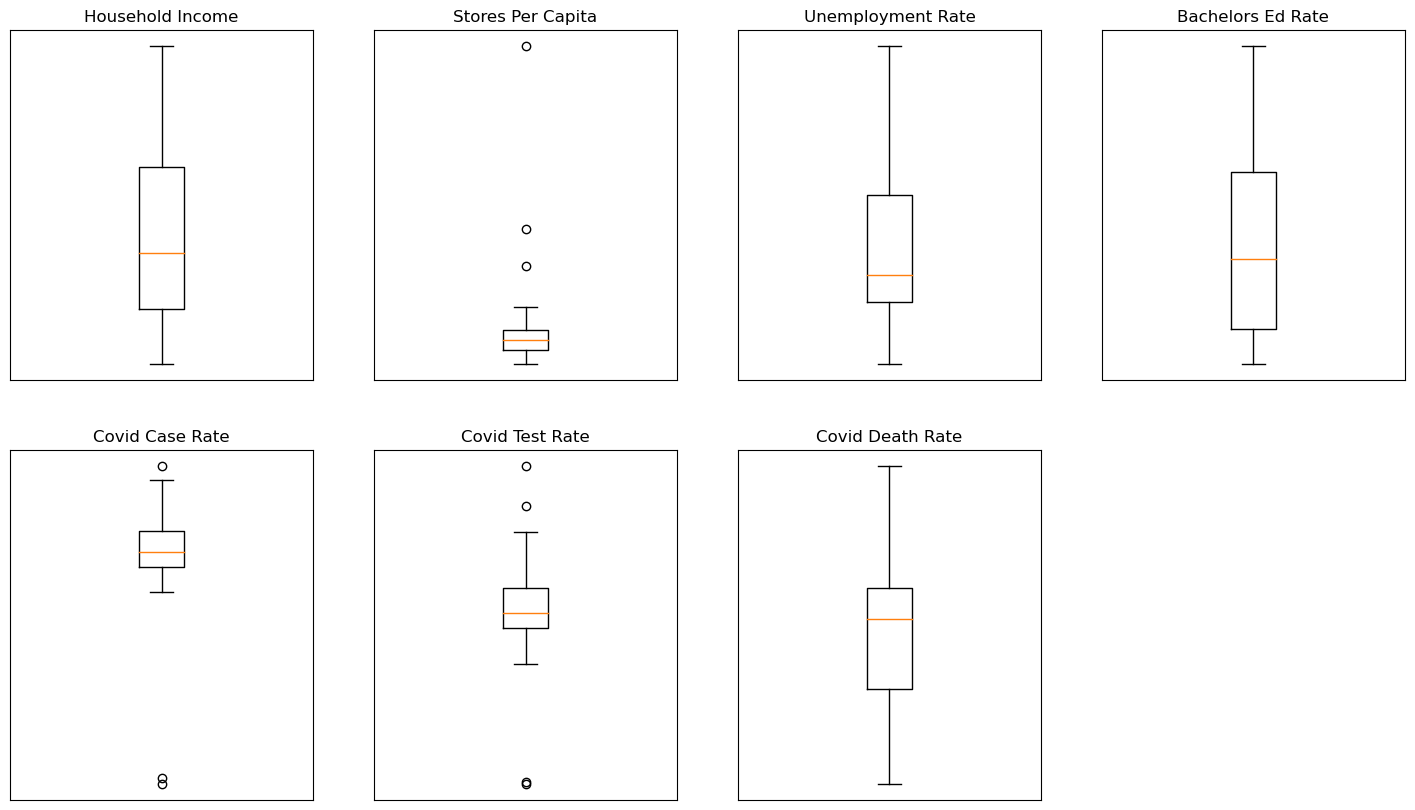

In [48]:
# boxplots to visualize which variables have outliers
chicago_nums=chicago.select_dtypes(exclude=['object'])
chicago_nums=chicago[["Household Income", "Stores Per Capita", "Unemployment Rate", "Bachelors Ed Rate", "Covid Case Rate", "Covid Test Rate", "Covid Death Rate" ]]
plt.figure(figsize=(18, 10))
for i, column in enumerate(chicago_nums):
    ax = plt.subplot(2, 4, i + 1)
    plt.boxplot(chicago_nums[column])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(column, wrap=True)
plt.savefig('Outliers_boxplots.png')

In [17]:
# after discussion, we decided to eliminate outliers by analysis instead of across all analyses, so outlier exclusion was done on a case-by-case basis. 

# Jen's analyses

r = -0.07, p = 0.63
r = 0.27, p = 0.05
r = -0.4, p = 0.0


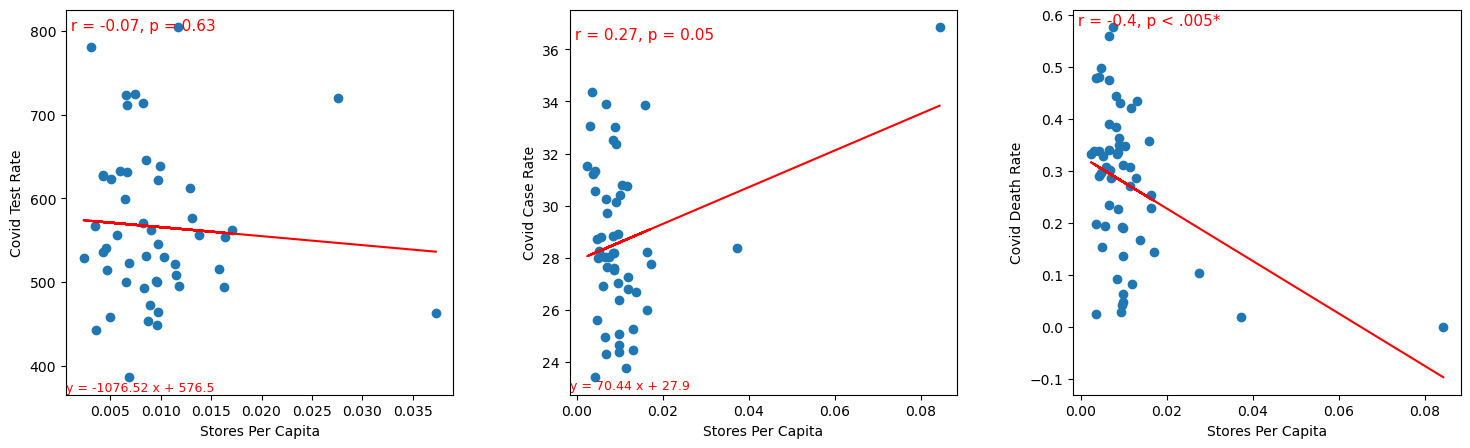

In [54]:
# To determine whether there was a relationship between the number of stores and the covid rates, regression analyses were run between stores per capita and the three different covid rates
x_col = "Stores Per Capita"
y_cols=["Covid Test Rate", "Covid Case Rate", "Covid Death Rate"]


chicago_filt=chicago
plt.figure(figsize=(18, 5))
for i, cols in enumerate(y_cols):
    q1 = chicago_filt[cols].quantile(0.25)
    q3 = chicago_filt[cols].quantile(0.75)
    iqr=q3-q1
    upper = q3 + (1.5*iqr)
    lower = q1 - (1.5*iqr)
    chicago_filt2 = chicago_filt[(chicago_filt[cols] < upper) & (chicago_filt[cols] > lower)]


    y = chicago_filt2[cols]
    x = chicago_filt2[x_col]

    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = f"y = {round(slope,2)} x + {round(intercept,2)}"
    ax = plt.subplot(1, len(y_cols), i + 1)
    plt.subplots_adjust(wspace = .3)
    plt.scatter(x, y)
    plt.plot(x,regress_values,"r-")
    xlims=ax.get_xlim()
    ylims=ax.get_ylim()
    if pvalue < .005:
        plt.annotate(f" r = {round(rvalue,2)}, p < .005*",(xlims[0],ylims[1]*.95),fontsize=11,color="red")
    elif pvalue < .05:
        plt.annotate(f" r = {round(rvalue,2)}, p = {round(pvalue,2)}*",(xlims[0],ylims[1]*.97),fontsize=11,color="red")
    else:
        plt.annotate(f" r = {round(rvalue,2)}, p = {round(pvalue,2)}",(xlims[0],ylims[1]*.97),fontsize=11,color="red")
    plt.annotate(line_eq,(xlims[0],ylims[0]*1.01),fontsize=10,color="red")
    plt.xlabel(x_col)

    plt.ylabel(cols)

    print(f"r = {round(rvalue, 2)}, p = {round(pvalue,2)}")
    plt.savefig('Stores_v_covid_notransform.png')


r = -0.08, p = 0.58
r = 0.01, p = 0.97
r = -0.41, p = 0.0


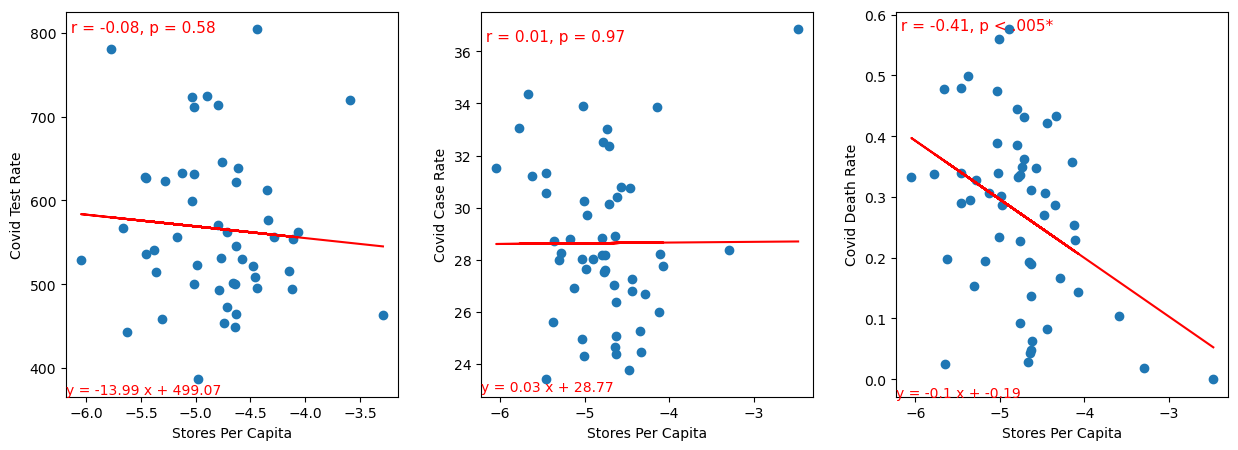

In [66]:
# Same analyses as previous cell but with log transform of store data. 
x_col = "Stores Per Capita"
y_cols=["Covid Test Rate", "Covid Case Rate", "Covid Death Rate"]


chicago_filt=chicago
plt.figure(figsize=(15, 5))
for i, cols in enumerate(y_cols):
    q1 = chicago_filt[cols].quantile(0.25)
    q3 = chicago_filt[cols].quantile(0.75)
    iqr=q3-q1
    upper = q3 + (1.5*iqr)
    lower = q1 - (1.5*iqr)
    chicago_filt2 = chicago_filt[(chicago_filt[cols] < upper) & (chicago_filt[cols] > lower)]


    y = chicago_filt2[cols]
    x = chicago_filt2[x_col]
    x=np.log(x) # log-transform store data to normalize distribution

    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = f"y = {round(slope,2)} x + {round(intercept,2)}"
    ax = plt.subplot(1, len(y_cols), i + 1)
    plt.subplots_adjust(wspace = .25)
    plt.scatter(x, y)
    plt.plot(x,regress_values,"r-")
    xlims=ax.get_xlim()
    ylims=ax.get_ylim()
    if pvalue < .005:
        plt.annotate(f" r = {round(rvalue,2)}, p < .005*",(xlims[0],ylims[1]*.95),fontsize=11,color="red")
    elif pvalue < .05:
        plt.annotate(f" r = {round(rvalue,2)}, p = {round(pvalue,2)}*",(xlims[0],ylims[1]*.97),fontsize=11,color="red")
    else:
        plt.annotate(f" r = {round(rvalue,2)}, p = {round(pvalue,2)}",(xlims[0],ylims[1]*.97),fontsize=11,color="red")
    plt.annotate(line_eq,(xlims[0],ylims[0]*1.01),fontsize=10,color="red")
    plt.xlabel(x_col)

    plt.ylabel(cols)

    print(f"r = {round(rvalue, 2)}, p = {round(pvalue,2)}")
    plt.savefig('Stores_v_covid_withtransform.png')


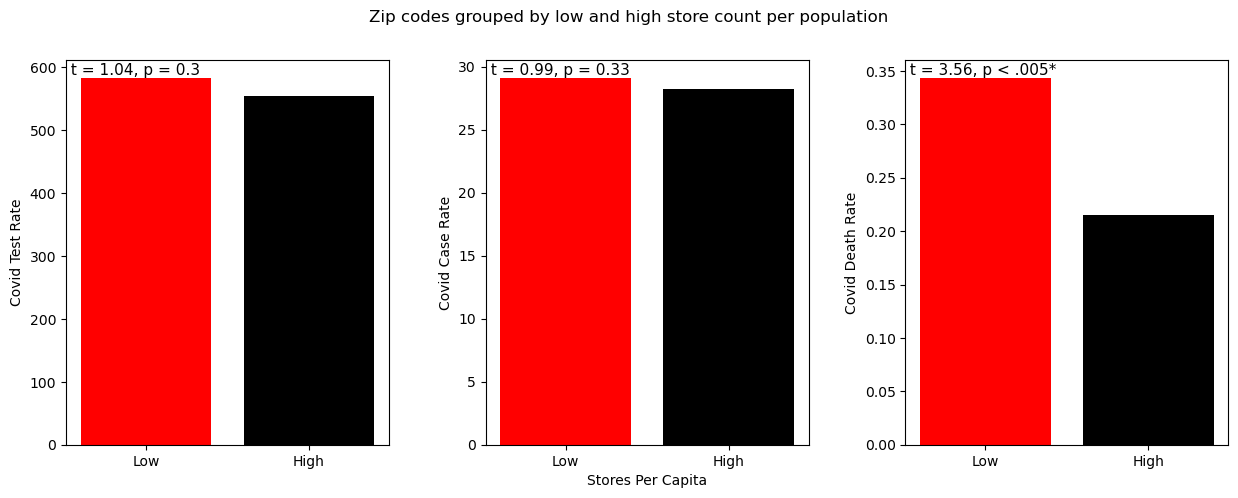

In [67]:
# Mean split of stores per capita to create two groups. For each covid measure, a t-test was run between the two groups to determine whether zip codes with fewer stores per person 
# significantly differed in these covid rates from those with more stores per person.
x_col = "Stores Per Capita"
y_cols=["Covid Test Rate", "Covid Case Rate", "Covid Death Rate"]


chicago_filt=chicago
plt.figure(figsize=(15, 5))
for i, cols in enumerate(y_cols):
    q1 = chicago_filt[cols].quantile(0.25)
    q3 = chicago_filt[cols].quantile(0.75)
    iqr=q3-q1
    upper = q3 + (1.5*iqr)
    lower = q1 - (1.5*iqr)
    chicago_filt2 = chicago_filt[(chicago_filt[cols] < upper) & (chicago_filt[cols] > lower)]


    y = chicago_filt2[cols]
    x = chicago_filt2[x_col]
    x=np.log(x)
    low=[]
    high=[]
    meanx=np.mean(x)
    for k, val in enumerate(x):
        if val < meanx:
           low.append(k)
        else:
           high.append(k)
    
    low_data=[]
    high_data=[]
    for j, val in enumerate(y):
         if j in low:
            low_data.append(val)
         else:
            high_data.append(val)
            
        
    ax = plt.subplot(1, len(y_cols), i + 1)
    plt.subplots_adjust(wspace = .3)
    plt.bar(1,np.mean(low_data), color="red")
    plt.bar(2,np.mean(high_data), color="black")
    
    plt.ylabel(cols)
    if i == 1:
      plt.xlabel(x_col)
      plt.suptitle("Zip codes grouped by low and high store count per population", horizontalalignment="center")

    ax.set_xticks([1,2])
    ax.set_xticklabels(["Low", "High"])


    stats=st.ttest_ind(low_data, high_data, equal_var=False)
    xlims=ax.get_xlim()
    ylims=ax.get_ylim()
    if stats[1] <.005:
        plt.annotate(f" t = {round(stats[0],2)}, p < .005*",(xlims[0],ylims[1]*.96),fontsize=11,color="black")
    elif stats[1] <.05:
        plt.annotate(f" t = {round(stats[0],2)}, p = {round(stats[1],2)}*",(xlims[0],ylims[1]*.96),fontsize=11,color="black")
    else:
        plt.annotate(f" t = {round(stats[0],2)}, p = {round(stats[1],2)}",(xlims[0],ylims[1]*.96),fontsize=11,color="black")

    plt.savefig('Stores_transformed_covid_bars.png')
    


r = 0.51, p = 0.0
r = -0.66, p = 0.0


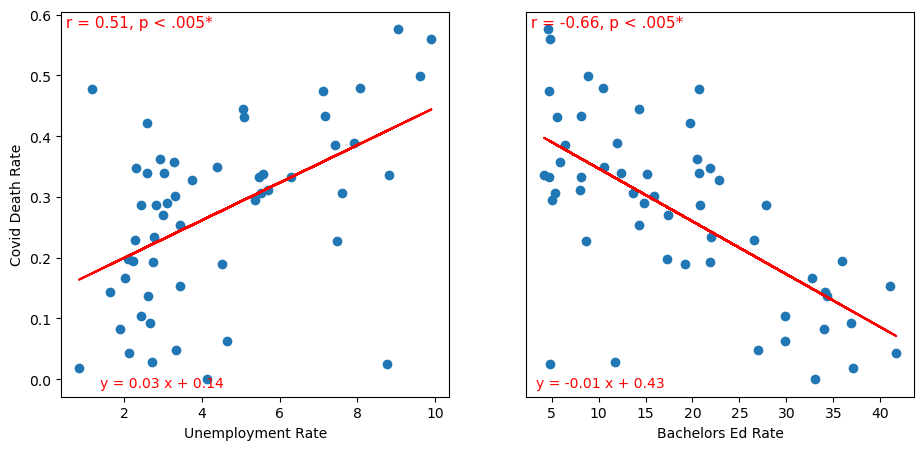

In [68]:
# Regression to determine whether other demographic factors (unemployment rate and education rate) predicted covid death rate
y_col = "Covid Death Rate"
#x_cols=["Unemployment Rate", "No Education Rate", "High School Ed Rate", "GED Rate", "Bachelors Ed Rate"]
x_cols=["Unemployment Rate", "Bachelors Ed Rate"]

q1 = chicago[y_col].quantile(0.25)
q3 = chicago[y_col].quantile(0.75)
iqr=q3-q1
upper = q3 + (1.5*iqr)
lower = q1 - (1.5*iqr)
chicago_filt = chicago[(chicago[y_col] < upper) & (chicago[y_col] > lower)]

plt.figure(figsize=(11, 5))
for i, cols in enumerate(x_cols):
    q1 = chicago_filt[cols].quantile(0.25)
    q3 = chicago_filt[cols].quantile(0.75)
    iqr=q3-q1
    upper = q3 + (1.5*iqr)
    lower = q1 - (1.5*iqr)
    chicago_filt2 = chicago_filt[(chicago_filt[cols] < upper) & (chicago_filt[cols] > lower)]


    x = chicago_filt2[cols]
    y = chicago_filt2[y_col]

    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = f"y = {round(slope,2)} x + {round(intercept,2)}"
    ax = plt.subplot(1, len(x_cols), i + 1)
    plt.scatter(x, y)
    plt.plot(x,regress_values,"r-")
    xlims=ax.get_xlim()
    ylims=ax.get_ylim()
    if pvalue < .005:
        plt.annotate(f" r = {round(rvalue,2)}, p < .005*",(xlims[0],ylims[1]-.025),fontsize=11,color="red")
    elif pvalue < .05:
        plt.annotate(f" r = {round(rvalue,2)}, p = {round(pvalue,2)}*",(xlims[0],ylims[1]-.025),fontsize=11,color="red")
    else:
        plt.annotate(f" r = {round(rvalue,2)}, p = {round(pvalue,2)}",(xlims[0],ylims[1]-.025),fontsize=11,color="red")
    plt.annotate(line_eq,(xlims[0]+1,ylims[0]+.015),fontsize=10,color="red")
    plt.xlabel(cols)
    if i == 0:
        plt.ylabel(y_col)
    else:
        ax.set_yticks([])

    print(f"r = {round(rvalue, 2)}, p = {round(pvalue,2)}")
    plt.savefig("Covid_deaths_ed.png")


r = -0.74, p = 1.4657934174579785e-10
r = 0.86, p = 3.6315582882007907e-17


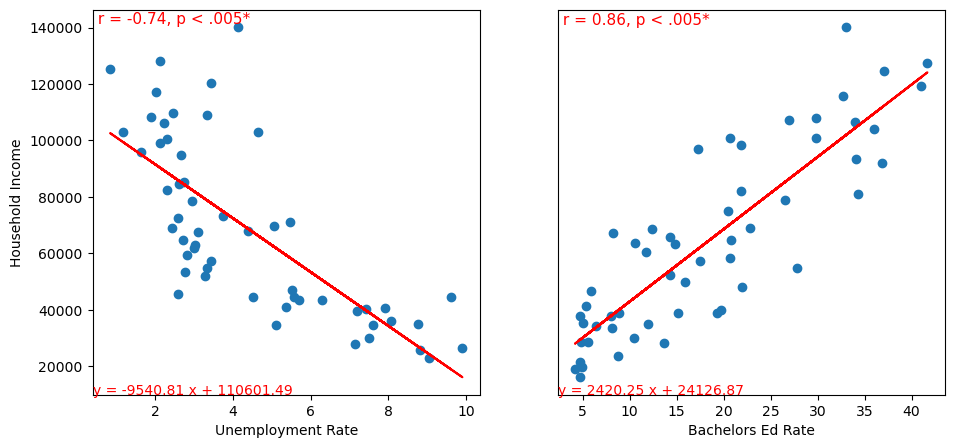

In [69]:
# Regression to determine whether demographic factors (unemployment rate and education rate) predicted household income
y_col = "Household Income"
x_cols=["Unemployment Rate", "Bachelors Ed Rate"]

q1 = chicago[y_col].quantile(0.25)
q3 = chicago[y_col].quantile(0.75)
iqr=q3-q1
upper = q3 + (1.5*iqr)
lower = q1 - (1.5*iqr)
chicago_filt = chicago[(chicago[y_col] < upper) & (chicago[y_col] > lower)]

plt.figure(figsize=(11, 5))
for i, cols in enumerate(x_cols):
    q1 = chicago_filt[cols].quantile(0.25)
    q3 = chicago_filt[cols].quantile(0.75)
    iqr=q3-q1
    upper = q3 + (1.5*iqr)
    lower = q1 - (1.5*iqr)
    chicago_filt2 = chicago_filt[(chicago_filt[cols] < upper) & (chicago_filt[cols] > lower)]


    x = chicago_filt2[cols]
    y = chicago_filt2[y_col]

    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = f"y = {round(slope,2)} x + {round(intercept,2)}"
    ax = plt.subplot(1, len(x_cols), i + 1)
    plt.scatter(x, y)
    plt.plot(x,regress_values,"r-")
    xlims=ax.get_xlim()
    ylims=ax.get_ylim()
    if pvalue < .005:
        plt.annotate(f" r = {round(rvalue,2)}, p < .005*",(xlims[0],ylims[1]-5000),fontsize=11,color="red")
    elif pvalue < .05:
        plt.annotate(f" r = {round(rvalue,2)}, p = {round(pvalue,2)}*",(xlims[0],ylims[1]-5000),fontsize=11,color="red")
    else:
        plt.annotate(f" r = {round(rvalue,2)}, p = {round(pvalue,2)}",(xlims[0],ylims[1]-5000),fontsize=11,color="red")
    
    plt.annotate(line_eq,(xlims[0],ylims[0]),fontsize=10,color="red")
    plt.xlabel(cols)
    if i == 0:
        plt.ylabel(y_col)
    else:
        ax.set_yticks([])

    print(f"r = {round(rvalue, 2)}, p = {pvalue}")
    plt.savefig("Income_Ed.png")

r = -0.31, p = 0.03
r = 0.22, p = 0.12


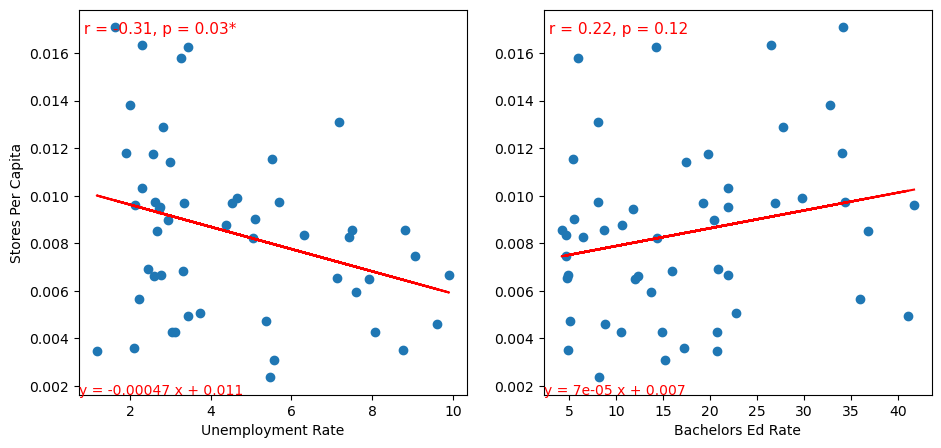

In [72]:
# Regression to determine whether demographic factors (unemployment rate and education rate) predicted stores per capita
y_col = "Stores Per Capita"
x_cols=["Unemployment Rate", "Bachelors Ed Rate"]

q1 = chicago[y_col].quantile(0.25)
q3 = chicago[y_col].quantile(0.75)
iqr=q3-q1
upper = q3 + (1.5*iqr)
lower = q1 - (1.5*iqr)
chicago_filt = chicago[(chicago[y_col] < upper) & (chicago[y_col] > lower)]

plt.figure(figsize=(11, 5))
for i, cols in enumerate(x_cols):
    q1 = chicago_filt[cols].quantile(0.25)
    q3 = chicago_filt[cols].quantile(0.75)
    iqr=q3-q1
    upper = q3 + (1.5*iqr)
    lower = q1 - (1.5*iqr)
    chicago_filt2 = chicago_filt[(chicago_filt[cols] < upper) & (chicago_filt[cols] > lower)]


    x = chicago_filt2[cols]
    y = chicago_filt2[y_col]

    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = f"y = {round(slope,5)} x + {round(intercept,3)}"
    ax = plt.subplot(1, len(x_cols), i + 1)
    plt.scatter(x, y)
    plt.plot(x,regress_values,"r-")
    xlims=ax.get_xlim()
    ylims=ax.get_ylim()
    if pvalue < .05:
        plt.annotate(f" r = {round(rvalue,2)}, p = {round(pvalue,2)}*",(xlims[0],ylims[1]-.001),fontsize=11,color="red")
    else:
        plt.annotate(f" r = {round(rvalue,2)}, p = {round(pvalue,2)}",(xlims[0],ylims[1]-.001),fontsize=11,color="red")
    plt.annotate(line_eq,(xlims[0],ylims[0]),fontsize=10,color="red")
    plt.xlabel(cols)
    if i == 0:
        plt.ylabel(y_col)

    print(f"r = {round(rvalue, 2)}, p = {round(pvalue,2)}")
    plt.savefig("Stores_Ed.png")

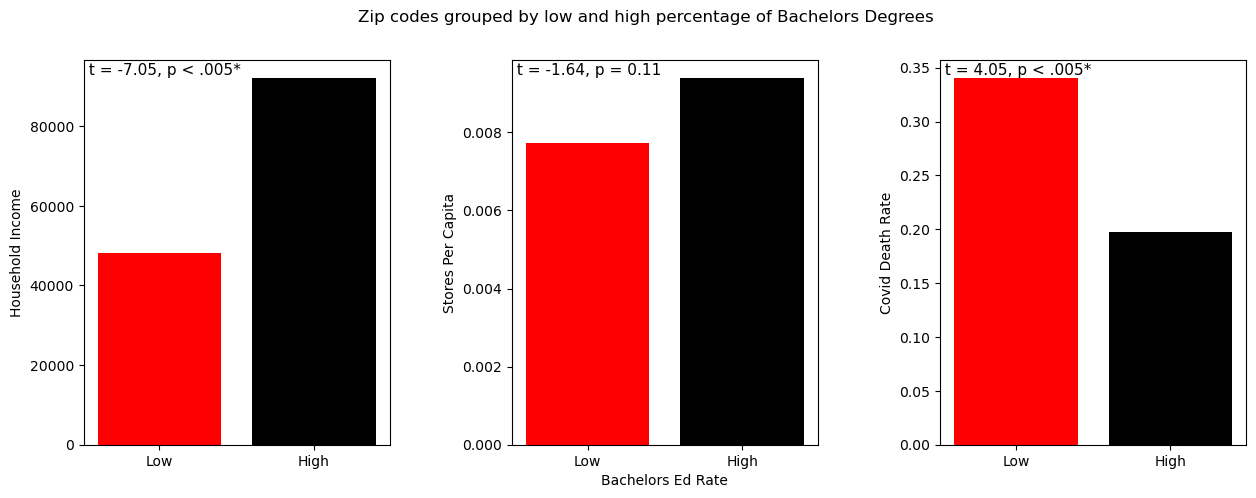

In [73]:
# Mean split of bachelors degree rate to create two groups. For household income, stores per capita, and covid death rate, a t-test was run between the two groups to determine whether zip codes with  
# a lower rate of persons with bachelors degrees significantly differed in these covid rates from those with more people with bachelors degrees.
x_col = "Bachelors Ed Rate"
y_cols=["Household Income", "Stores Per Capita", "Covid Death Rate"]


chicago_filt=chicago
plt.figure(figsize=(15, 5))
for i, cols in enumerate(y_cols):
    q1 = chicago_filt[cols].quantile(0.25)
    q3 = chicago_filt[cols].quantile(0.75)
    iqr=q3-q1
    upper = q3 + (1.5*iqr)
    lower = q1 - (1.5*iqr)
    chicago_filt2 = chicago_filt[(chicago_filt[cols] < upper) & (chicago_filt[cols] > lower)]


    y = chicago_filt2[cols]
    x = chicago_filt2[x_col]
    
    low=[]
    high=[]
    meanx=np.mean(x)
    for k, val in enumerate(x):
        if val < meanx:
           low.append(k)
        else:
           high.append(k)
    
    low_data=[]
    high_data=[]
    for j, val in enumerate(y):
         if j in low:
            low_data.append(val)
         else:
            high_data.append(val)
            
        
    ax = plt.subplot(1, len(y_cols), i + 1)
    plt.subplots_adjust(wspace = .4)
    plt.bar(1,np.mean(low_data), color="red")
    plt.bar(2,np.mean(high_data), color="black")
    
    plt.ylabel(cols)
    if i == 1:
      plt.xlabel(x_col)
      plt.suptitle("Zip codes grouped by low and high percentage of Bachelors Degrees", horizontalalignment="center")

    ax.set_xticks([1,2])
    ax.set_xticklabels(["Low", "High"])


    stats=st.ttest_ind(low_data, high_data, equal_var=False)
    xlims=ax.get_xlim()
    ylims=ax.get_ylim()
    if stats[1] <.005:
        plt.annotate(f" t = {round(stats[0],2)}, p < .005*",(xlims[0],ylims[1]*.96),fontsize=11,color="black")
    elif stats[1] <.05:
        plt.annotate(f" t = {round(stats[0],2)}, p = {round(stats[1],2)}*",(xlims[0],ylims[1]*.96),fontsize=11,color="black")
    else:
        plt.annotate(f" t = {round(stats[0],2)}, p = {round(stats[1],2)}",(xlims[0],ylims[1]*.96),fontsize=11,color="black")

    plt.savefig('bachelor_bars.png')
    


## Roxanne's analyses

In [ ]:

#making box plots for the 4 quartiles of zip codes by average household income
# create 4 divisions of zip codes by average wealth compared to the other zips
wealth_areas = ["poorest", "second_poorest", "second_wealthiest", "wealthiest"]

wealth_quants = chicago["Household Income"].quantile([.25,.5,.75])
print(wealth_quants)
chicago["Household Income"].max()

#for a zip code whose wealth is between $0 and the limit of Q1, we need them to be labeled as poorest

#for a zip code whose wealth is between the limit of Q1 and the average Chicago household income, 
# we need them to be labeled as second_poorest

#for a zip code whose wealth is between the average Chicago household income and the limit of Q3, 
# we need them to be labeled as second_wealthiest

#for a zip code whose wealth is between the value of q3 and the maximum average household income zip in Chicago, 
# we need them to be labeled as wealthiest

bins = [0, 43439.5, 63889.5, 95676.0, 140125.0]
chicago["Household Income Quartile"] = pd.cut(chicago["Household Income"], bins, labels=wealth_areas)
chicago.head()

#Note: we found there are no outliers for any zip codes' average household incomes.


0.25    43439.5
0.50    63889.5
0.75    95676.0
Name: Household Income, dtype: float64


,Zipcode,Name,Household Income,Population,Median Age,Per Capita Income,Poverty Count,Num No Education,Num High School,Num GED,...,Poverty Rate,Unemployment Rate,No Education Rate,High School Ed Rate,GED Rate,Bachelors Ed Rate,Covid Case Rate,Covid Test Rate,Covid Death Rate,Household Income Quartile
0,60629,ZCTA5 60629,43372.0,107930.0,31.3,19159.0,20230.0,2884.0,22274.0,3191.0,...,18.743630,6.300380,2.672102,20.637450,2.956546,4.693783,32.502548,492.804596,0.332623,poorest
1,60618,ZCTA5 60618,85443.0,94646.0,34.4,47550.0,8382.0,1433.0,10468.0,1541.0,...,8.856159,2.741796,1.514063,11.060161,1.628172,21.869915,27.039706,501.876466,0.192296,second_wealthiest
2,60639,ZCTA5 60639,51810.0,88515.0,34.6,21614.0,15257.0,3288.0,14583.0,2615.0,...,17.236627,3.272892,3.714625,16.475174,2.954302,5.916511,33.865447,515.712591,0.357002,second_poorest
3,60647,ZCTA5 60647,82433.0,85658.0,32.2,51166.0,10750.0,1095.0,9665.0,1417.0,...,12.549908,2.289337,1.278339,11.283243,1.654253,26.493731,28.227369,553.778982,0.228817,second_wealthiest
5,60632,ZCTA5 60632,46937.0,86715.0,31.4,18927.0,13916.0,2944.0,18401.0,2417.0,...,16.047973,5.523842,3.395030,21.220089,2.787292,5.395837,30.743239,508.600588,0.306752,second_poorest


Text(0, 0.5, 'Average Household Income in the Zip ($)')

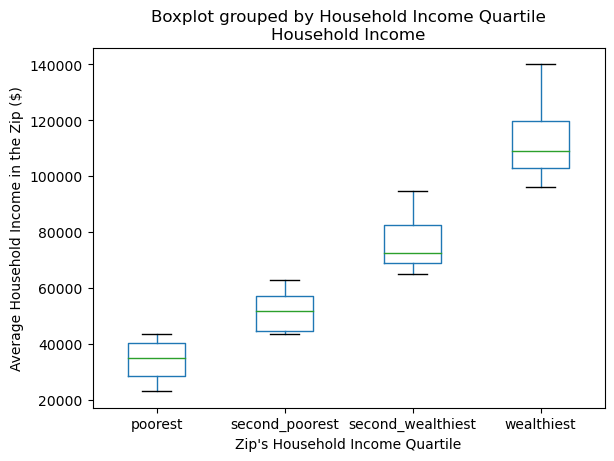

In [ ]:
ax = chicago.boxplot(column="Household Income", by = "Household Income Quartile", grid = False)
ax.set_xlabel("Zip's Household Income Quartile")
ax.set_ylabel("Average Household Income in the Zip ($)")

The Regression line is modeled by the equation y = 1.679e-07x + -0.0007651913
The r-value is: 0.44475023404704944
The p-value is: 0.0007531819043198361


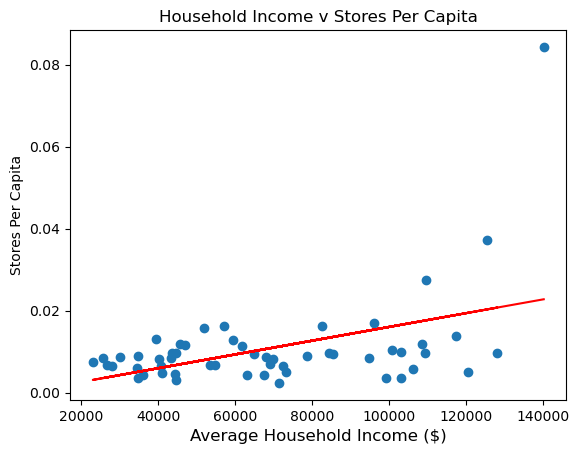

In [ ]:
#Now we want to show the relationship between the grocery stores per capita by zip code against
#the average household income of that zip

# generate a scatter plot of the grocery stores per capita by zip code against the average household 
# #income of that zip

plt.scatter(chicago["Household Income"],chicago["Stores Per Capita"])
plt.title('Household Income v Stores Per Capita')
plt.xlabel('Average Household Income ($)',fontsize =12)
plt.ylabel('Stores Per Capita')

#linear regression for store availability
x_values = chicago["Household Income"]
y_values = chicago["Stores Per Capita"]
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,10)) + "x + " + str(round(intercept,10))

print(f"The Regression line is modeled by the equation {line_eq}")
print(f"The r-value is: {rvalue}")
print(f"The p-value is: {pvalue}")

plt.plot(x_values, regress_values, "-r")
plt.savefig("Household Income v Stores Per Capita")

## Manali's analyses

The r-squared is: -0.40991015105719636


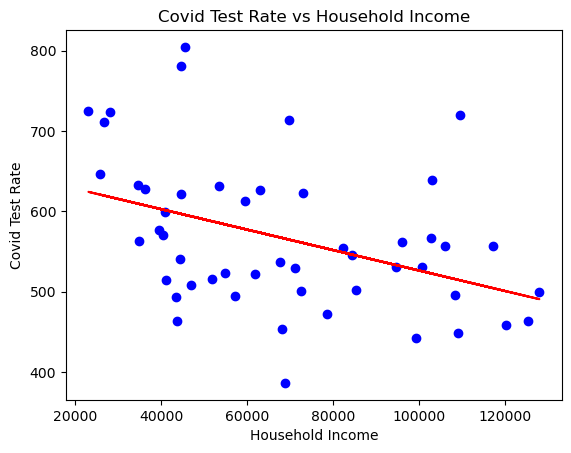

In [ ]:
#covid test rate
q1 = chicago["Covid Test Rate"].quantile(0.25)
q3 = chicago["Covid Test Rate"].quantile(0.75)

iqr=q3-q1

upper = q3 + (1.5*iqr)
lower = q1 - (1.5*iqr)

chicago_filt = chicago[(chicago["Covid Test Rate"] < upper) & (chicago["Covid Test Rate"] > lower)]



x=chicago_filt["Household Income"]
y=chicago_filt["Covid Test Rate"]
#linear regression code
slope=st.linregress(x,y)
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
#scatter plot code
plt.scatter(x,y,c="blue")
plt.title("Covid Test Rate vs Household Income")
plt.xlabel("Household Income")
plt.ylabel("Covid Test Rate")
#printing r value
print(f"The r-squared is: {rvalue}")
plt.plot(x,regress_values,"-r")
plt.savefig("Covid Test Rate vs Household Income")
plt.show()

The r-squared is: -0.6624316427733499


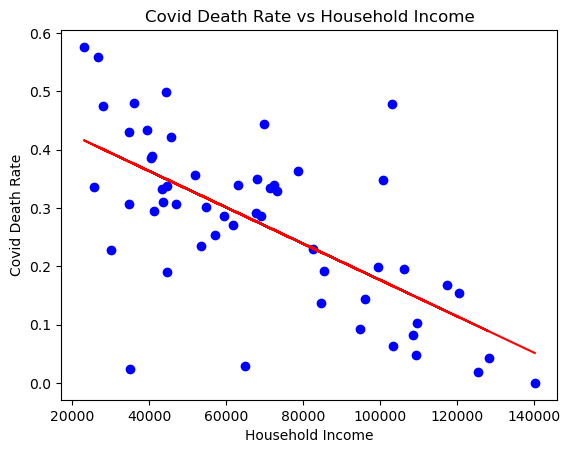

In [ ]:
#covid death rate
q1 = chicago["Covid Death Rate"].quantile(0.25)
q3 = chicago["Covid Death Rate"].quantile(0.75)

iqr=q3-q1

upper = q3 + (1.5*iqr)
lower = q1 - (1.5*iqr)

chicago_filt = chicago[(chicago["Covid Death Rate"] < upper) & (chicago["Covid Death Rate"] > lower)]


x=chicago_filt["Household Income"]
y=chicago_filt["Covid Death Rate"]
#linear regression code
slope=st.linregress(x,y)
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
#scatter plot code
plt.scatter(x,y,c="blue")
plt.title("Covid Death Rate vs Household Income")
plt.xlabel("Household Income")
plt.ylabel("Covid Death Rate")
#r value
print(f"The r-squared is: {rvalue}")
plt.plot(x,regress_values,'-r')
plt.savefig("Covid Death Rate vs Household Income")
plt.show()

The r-squared is: 0.22350997476733586
The Regression line is modeled by the equation y = 2.19e-05x + 27.14


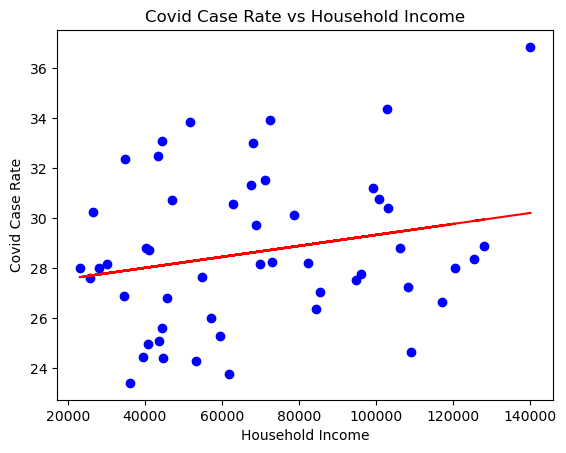

In [ ]:
q1 = chicago['Covid Case Rate'].quantile(0.25)
q3 = chicago['Covid Case Rate'].quantile(0.75)
iqr=q3-q1
upper = q3 + (1.5*iqr)
lower = q1 - (1.5*iqr)
chicago_filt = chicago[(chicago['Covid Case Rate'] < upper) & (chicago['Covid Case Rate'] > lower)]
x=chicago_filt['Household Income']
y=chicago_filt['Covid Case Rate']
#linear regression code
slope=st.linregress(x,y)
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x, y)
regress_values = x * slope + intercept
line_eq = 'y = ' + str(round(slope,7)) + 'x + ' + str(round(intercept,2))
#scatter plot code
plt.scatter(x,y,c='blue')
plt.title('Covid Case Rate vs Household Income')
plt.xlabel('Household Income')
plt.ylabel('Covid Case Rate')
#printing r value
print(f'The r-squared is: {rvalue}')
print(f'The Regression line is modeled by the equation {line_eq}')
plt.plot(x,regress_values,'-r')
plt.savefig('Covid Case Rate vs Household Income.png')
plt.show()